# Задание 4. Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import numpy as np
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Полные данные, аналитически

In [3]:
def train_test_split(X, Y, train_percent : float =0.25):
    p = np.random.permutation(len(X))
    X1 = X[p]
    Y1 = Y[p]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    for i in range(len(X)):
        if i % 5 == 0:
            x_test.append(X1[i])
            y_test.append(Y1[i])
        else:
            x_train.append(X1[i])
            y_train.append(Y1[i])
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [4]:
x_train, y_train, x_test, y_test = train_test_split(X, Y)

In [5]:
def Q(X, Y, theta, alpha:float)->float:
    l = len(X)
    return sum([(Y[i] - X[i] @ theta).T*(Y[i] - X[i] @ theta)  for i in range(l)])/l

In [6]:
def find_theta(X, Y, alpha: float)->list:
    n = len(X[0])
    l = len(X)
    theta = np.linalg.inv(X.T @ X + alpha * np.identity(n)) @ X.T @ Y
    return theta

def solve(x:list, X, Y, alpha:float)->float:
    theta = find_theta(X,Y,alpha)
    y = np.array(x).T@theta
    return y

def plot():
    alphas = np.arange(0.01, 30, 0.1)
    thetas = [find_theta(x_train, y_train, alpha) for alpha in alphas]  # get parameters on train
    Qs_train = [Q(x_train, y_train, thetas[i], alphas[i]) for i in range(len(alphas))]  # get loss on train
    Qs_test = [Q(x_test, y_test, thetas[i], alphas[i]) for i in range(len(alphas))]  # get loss on test
    plt.plot(alphas, Qs_train, label = 'train')
    plt.plot(alphas, Qs_test, label = 'test')
    plt.title('Среднеквадратичная ошибка')
    plt.xlabel('alpha')
    plt.ylabel('Q(alpha)')
    plt.legend()

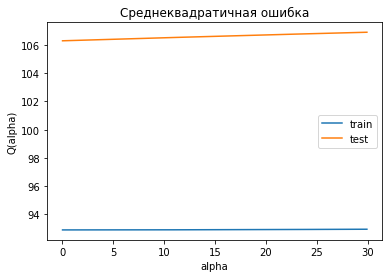

In [7]:
plot()

# 5-fold CV, градиентный спуск

In [8]:
def lin_reg_grad_descent(x_train, y_train, x_test, y_test, n_iter, lr, alpha):
    l, n = x_train.shape
    A = np.hstack([np.ones((l, 1)), x_train])
    B = np.hstack([np.ones((x_test.shape[0], 1)), x_test])
    theta = np.zeros(n + 1)
    losses = []
    losses_val = []
    for _ in range(n_iter):
        y_pred = A.dot(theta) 
        errors = y_train - y_pred
        loss = np.mean(errors**2) + alpha * np.sum(theta**2)
        grad = -(2 * A.T @ errors + 2*alpha * theta)/l
        theta -= lr * grad
        losses.append(loss) 
        loss_val = sum((y_test-B @ theta)**2)/B.shape[0] + alpha * np.sum(theta**2)
        losses_val.append(loss_val)
    return loss, loss_val

In [9]:
# shuffle arrays
def cv_grad_lin_reg(X, Y, n_iter, lr, alpha):
    np.random.seed(42)
    p = np.random.permutation(len(X))
    X1 = X[p]
    Y1 = Y[p]
    X_folds = [[],[],[],[],[]]
    Y_folds = [[],[],[],[],[]]
    l = len(X)
    for i in range(l):
        if i % 5 == 0:
            X_folds[0].append(X1[i])
            Y_folds[0].append(Y1[i])
        elif i % 5 == 1:
            X_folds[1].append(X1[i])
            Y_folds[1].append(Y1[i])
        elif i % 5 == 2:
            X_folds[2].append(X1[i])
            Y_folds[2].append(Y1[i])
        elif i % 5 == 3:
            X_folds[3].append(X1[i])
            Y_folds[3].append(Y1[i])
        elif i % 5 == 4:
            X_folds[4].append(X1[i])
            Y_folds[4].append(Y1[i])

    loss_train_all = []
    loss_val_all = []
    for i in range(5):
        x_train_i = [X_folds[j] for j in range(5) if j != i]
        y_train_i = [Y_folds[j] for j in range(5) if j != i]
        x_test_i = np.array(X_folds[i])
        y_test_i = Y_folds[i]
        x_train_i = np.reshape(x_train_i, (int(len(X)*4/5),4))
        y_train_i = np.reshape(y_train_i, (int(len(X)*4/5),))

        x_train_i = (x_train_i - np.mean(x_train_i, axis=0)) / np.std(x_train_i, axis=0)
        x_test_i = (x_test_i - np.mean(x_test_i, axis=0)) / np.std(x_test_i, axis=0)
        loss_train, loss_val = lin_reg_grad_descent(x_train_i, y_train_i, x_test_i, y_test_i, n_iter, lr, alpha)
        loss_train_all.append(loss_train)
        loss_val_all.append(loss_val)
    loss_train = np.mean(loss_train_all)
    loss_val = np.mean(loss_val_all)
    return loss_train, loss_val

train_loss:  111.03880138265986
val_loss:  152.28133975196738
alpha_opt:  0.001


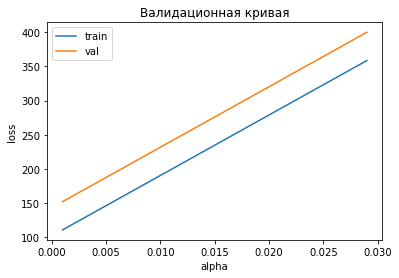

In [10]:
alphas = np.arange(0.001, 0.03, 0.001)
loss_train_alphas = []
loss_val_alphas = []
for alpha in alphas:
    loss_train, loss_val = cv_grad_lin_reg(X, Y, 250, 1e-2, alpha)
    loss_train_alphas.append(loss_train)
    loss_val_alphas.append(loss_val)
alpha_opt = alphas[np.argmin(loss_val_alphas)]
print('train_loss: ', np.min(loss_train_alphas))
print('val_loss: ', np.min(loss_val_alphas))
print('alpha_opt: ', alpha_opt)

plt.plot(alphas, loss_train_alphas, label='train')
plt.plot(alphas, loss_val_alphas, label='val')
plt.title('Валидационная кривая')
plt.xlabel('alpha')
plt.ylabel('loss')
plt.legend()

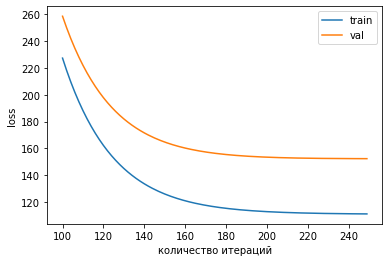

In [11]:
loss_train_iter = []
loss_val_iter = []
iters = range(100, 250)
for n_iter in iters:
    loss_train, loss_val = cv_grad_lin_reg(X, Y, n_iter, 1e-2, alpha_opt)
    loss_train_iter.append(loss_train)
    loss_val_iter.append(loss_val)
plt.plot(iters, loss_train_iter, label ='train')
plt.plot(iters, loss_val_iter, label ='val')
plt.xlabel('количество итераций')
plt.ylabel('loss')
plt.legend()